In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
'''import sys
sys.path.insert(0, '/content/drive/My Drive/VGG/pyimagesearch')
from pyimagesearch import config

def plot_training(H, N, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)
'''
# derive the paths to the training, validation, and testing
# directories
trainPath = '/content/drive/My Drive/Face_Recognition/Training'
#os.path.sep.join([config.BASE_PATH, config.TRAIN])
valPath = '/content/drive/My Drive/Face_Recognition/val'
#os.path.sep.join([config.BASE_PATH, config.VAL])
testPath = '/content/drive/My Drive/Face_Recognition/testing'
#os.path.sep.join([config.BASE_PATH, config.TEST])

# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

# initialize the training generator
trainGen = trainAug.flow_from_directory(
	trainPath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=32)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	valPath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=32)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	testPath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=32)

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit_generator(
	trainGen,
	steps_per_epoch=40,
	validation_data=valGen,
	validation_steps=5,
	epochs=5)

# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict_generator(testGen,	steps=5)
predIdxs = np.argmax(predIdxs, axis=1)

#predIdxs = np.argmax(predIdxs, axis=1)
#print(classification_report(testGen.classes, predIdxs,target_names=testGen.class_indices.keys()))
#plot_training(H, 50, config.WARMUP_PLOT_PATH)

# reset our data generators
trainGen.reset()
valGen.reset()

# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
	layer.trainable = True

# loop over the layers in the model and show which ones are trainable
# or not
for layer in baseModel.layers:
	print("{}: {}".format(layer, layer.trainable))

# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit_generator(
	trainGen,
	steps_per_epoch=40,
	validation_data=valGen,
	validation_steps=5,
	epochs=5)

# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,steps=5)
predIdxs = np.argmax(predIdxs, axis=1)
#print(classification_report(testGen.classes, predIdxs,
#	target_names=testGen.class_indices.keys()))
#plot_training(H, 20, config.UNFROZEN_PLOT_PATH)



In [0]:
trainGen.class_indices

{'Emilia Clarke_train': 0,
 'Hanan_train': 1,
 'Kulin_train': 2,
 'Mohit_train': 3,
 'Rohan_train': 4,
 'Siddhartha_train': 5}

In [0]:
Classes=['Emilia Clarke','Hanan','Kulin','Mohit','Rohan','Siddhartha']

In [0]:
model.save('face_model.h5')

In [0]:
import numpy as np
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
test_image = image.load_img('/content/drive/My Drive/Face_Recognition/Prediction/Copy of Emilia Clarke1.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
#test_image = np.expand_dims(test_image, axis = 0)
#result = classifier.predict(test_image)
#print(result)
#training_set.class_indices
#if result == 0:
m_model = load_model('/content/drive/My Drive/Face_Recognition/face_model.h5')

# pass the image through the network to obtain our predictions
preds = m_model.predict(np.expand_dims(test_image, axis=0))[0]
i = np.argmax(preds)
label = Classes[i]
'''
if(i<3):
  label = Classes[i]
  print(label)
else:
  print("Unknown")
'''

'\nif(i<3):\n  label = Classes[i]\n  print(label)\nelse:\n  print("Unknown")\n'

In [0]:
from keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2

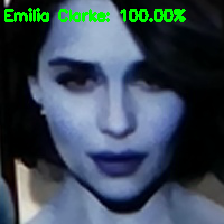

-1

In [0]:
text = "{}: {:.2f}%".format(label, preds[i] * 100)
cv2.putText(test_image, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0, 255, 0), 2)
# show the output image
cv2_imshow(test_image)
cv2.waitKey(0)